Question 1 - Part C (Thermal Storage with District Heating)

In [1]:
using CSV, DataFrames
df = CSV.read("C:\\Users\\kaush\\Downloads\\heat_demand_MW.csv",DataFrame)
T = 24*7 # Time Horizon
g = df[1:T,2]
c_p = 4.18 #kJ/kg-K for water

m_breaks = [10,50,150,300]
T_breaks = [10,15,20]
q_breaks = sort(vec(m_breaks .*c_p .* T_breaks'./1000))

a = 35 #$/MWh
b = 1.2 #$/(MWh)^2

function f(x)
    y = a.*x + b.*x.^2
    return y
end

f_values = f.(q_breaks)
N = length(f_values) - 1  # No. of segments for piecewise linear approximation
K = length(m_breaks) - 1 # No. of segments in m direction for MC envelopes
L = length(T_breaks) -1  # No. of segments in dT direction for MC envelopes

2

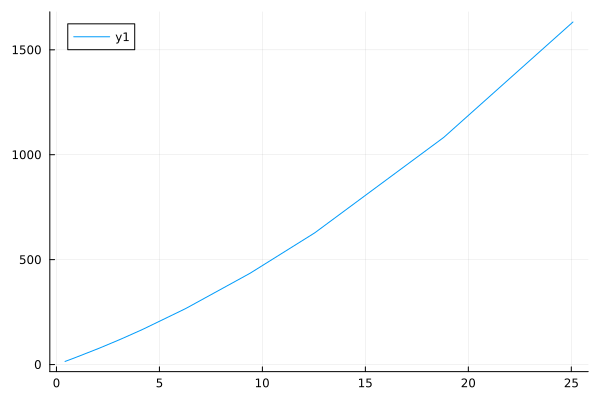

In [2]:
using Plots
plot(q_breaks, f_values)

In [3]:
c = 5000 # $/(MWh), Cost of Load Shedding (required, otherwise optimization without thermal storage is infeasible)
Q = 25 #MW, capacity
a_L = 10 #kg/s, mass flow rate (min)
a_U = 300 #kg/s, mass flow rate (max)
tau_L = 10 #K, temperature diff (min)
tau_U = 20 #K, temperature diff (max)
n_c = 0.95 # charging eff
n_d = 0.95 # discharging eff

E = 200 # MWh, storage capacity, Change here to calculate counterfactual

Pc = 50 # MW, charging limit
Pd = 50 # MW, discharging limit
d_U = 50 # ramp rate in kg/s

using JuMP, Gurobi
model = Model(Gurobi.Optimizer)

Set parameter Username
Set parameter LicenseID to value 2720373
Academic license - for non-commercial use only - expires 2026-10-09


A JuMP Model
├ solver: Gurobi
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

In [4]:
@variable(model, q[1:T] >= 0)
@variable(model, m[1:T] >= 0)
@variable(model, dT[1:T] >= 0)
@variable(model, S[1:T] >= 0)
@variable(model, rc[1:T] >= 0)
@variable(model, rd[1:T] >= 0)
@variable(model, l[1:T] >= 0)
@variable(model, alpha[1:N+1,1:T] >= 0)
@variable(model, y[1:T],Bin)
# Define constraints

# Supply-demand balance
@constraint(model, demand_balance[t=1:T], q[t] + rd[t] - rc[t] + l[t] >= g[t])

# Capacity constraints
@constraint(model,[t=1:T], q[t] .-Q <= 0)
@constraint(model,[t=1:T], a_L <= m[t] <= a_U)
@constraint(model,[t=1:T], tau_L <= dT[t] <= tau_U)

# Storage Dynamics

@constraint(model, S[1] == 0)  # initial condition
@constraint(model, rd[1] == 0)
@constraint(model,[t=2:T], S[t] == S[t-1] + n_c*rc[t] - 1/n_d*rd[t])
@constraint(model, S[T] == S[1])
@constraint(model,[t=1:T], S[t] <= E)
@constraint(model,[t=1:T], rc[t]*y[t] <= Pc)
@constraint(model,[t=1:T], rd[t]*(1-y[t]) <= Pd)

# Ramping constraint
@constraint(model,[t=1:T-1], m[t+1] - m[t] <= d_U)
# Define objective function as piecewise linear approximation over N segments

@objective(model, Min,
    sum(alpha[n,t] * f_values[n] for n in 1:(N+1), t in 1:T)
    + sum(c* l[t] for t in 1:T)
    )
@constraint(model, [t=1:T], [alpha[n,t] for n in 1:N+1] in SOS2())
@constraint(model, [t=1:T], sum(alpha[n,t] for n in 1:N+1) == 1)
@constraint(model, [t=1:T], q[t]==sum(alpha[n,t]*q_breaks[n] for n in 1:N+1))
#Mc-cormick envelopes for q = m*Cp*dT

@variable(model, Lambda[1:K, 1:L, 1:T],Bin)
@variable(model, r[1:K, 1:L, 1:T] >= 0)
@variable(model, s[1:K, 1:L, 1:T] >= 0)

@constraint(model, [t=1:T], sum(Lambda[i,j,t] for i in 1:K, j in 1:L) == 1)
@constraint(model, [t=1:T], m[t] == sum(r[i,j,t] for i in 1:K, j in 1:L))
@constraint(model, [t=1:T], dT[t] == sum(s[i,j,t] for i in 1:K, j in 1:L))


for t in 1:T, i in 1:K, j in 1:L
    @constraint(model, r[i,j,t] >= m_breaks[i] * Lambda[i,j,t])
    @constraint(model, r[i,j,t] <= m_breaks[i+1] * Lambda[i,j,t])
    @constraint(model, s[i,j,t] >= T_breaks[j] * Lambda[i,j,t])
    @constraint(model, s[i,j,t] <= T_breaks[j+1]* Lambda[i,j,t])
end

for t in 1:T
    #q_t <= c_p * Σ( m_{i+1} * s_ij + ΔT_j * r_ij - m_{i+1}*ΔT_j * λ_ij )
    @constraint(model,
        q[t] <= c_p /1000 * sum(
            m_breaks[i+1] * s[i,j,t] + T_breaks[j] * r[i,j,t] - m_breaks[i+1]*T_breaks[j]*Lambda[i,j,t]
            for i in 1:K, j in 1:L
        )
    )

    # q_t <= c_p * Σ( m_i * s_ij + ΔT_{j+1} * r_ij - m_i*ΔT_{j+1} * λ_ij )
    @constraint(model,
        q[t] <= c_p /1000 * sum(
            m_breaks[i] * s[i,j,t] + T_breaks[j+1] * r[i,j,t] - m_breaks[i]*T_breaks[j+1]*Lambda[i,j,t]
            for i in 1:K, j in 1:L
        )
    )
  
    # q_t >= c_p * Σ( m_i * s_ij + ΔT_j * r_ij - m_i*ΔT_j * λ_ij )
    @constraint(model,
        q[t] >= c_p /1000 * sum(
            m_breaks[i] * s[i,j,t] + T_breaks[j] * r[i,j,t] - m_breaks[i]*T_breaks[j]*Lambda[i,j,t]
            for i in 1:K, j in 1:L
        )
    )

    # q_t >= c_p * Σ( m_{i+1} * s_ij + ΔT_{j+1} * r_ij - m_{i+1}*ΔT_{j+1} * λ_ij )
    @constraint(model,
        q[t] >= c_p /1000 * sum(
            m_breaks[i+1] * s[i,j,t] + T_breaks[j+1] * r[i,j,t] - m_breaks[i+1]*T_breaks[j+1]*Lambda[i,j,t]
            for i in 1:K, j in 1:L
        )
    )
end

In [12]:
optimize!(model)

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: AMD Ryzen 7 7735U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
Presolve  0

Optimize a model with 6721 rows, 6720 columns and 31078 nonzeros
Model fingerprint: 0x851ad4fe
Model has 336 quadratic constraints
Model has 168 SOS constraints
Variable types: 6720 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [4e-02, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+01, 5e+03]
  Bounds range     [1e+00, 3e+02]
  RHS range        [1e+00, 2e+02]
  QRHS range       [5e+01, 5e+01]

Loaded MIP start from previous solve with objective 32089.8

         in product terms.
         Consider bounding these variables or reformulating the model.


Solving non-convex MIQCP

Variable types: 6718 continuous, 3 integer (0 binary

In [176]:
#no_storage_cost = objective_value(model)
with_storage_cost = objective_value(model)
no_storage_cost, with_storage_cost

(32342.557239999995, 32089.782482770075)

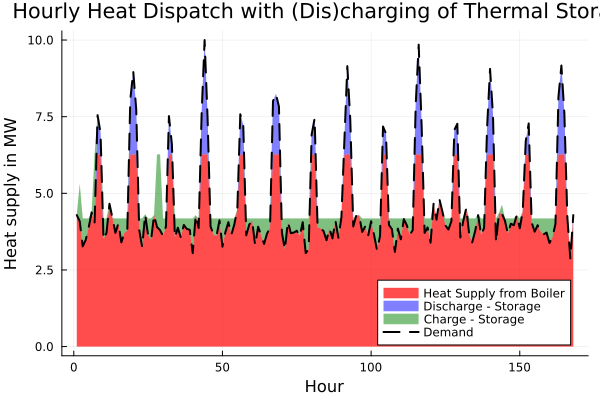

"C:\\Users\\kaush\\Downloads\\thermal_balance.png"

In [177]:
using JuMP, DataFrames

opt_q = value.(q)
opt_rc = value.(rc)
opt_rd = value.(rd)
opt_S = value.(S)
opt_l = value.(l)

df = DataFrame(
    time = 1:T,
    Heat_supplied = opt_q,
    Demand = g,
    Charging = opt_rc,
    Discharging = opt_rd,
    Storage = opt_S,
    Unmet_load = opt_l
)
# Net supply up to demand
total_supply = opt_q .+ opt_rd
net_supply = min.(total_supply, g)  # portion of supply + discharge used

# Portion of supply from discharge
discharge_used = min.(opt_rd, net_supply)  # discharge part up to demand
supply_used = net_supply .- discharge_used # supply part up to demand

# Excess going to charging
charge_excess = max.(0, total_supply .- g)

using Plots

# Compute cumulative sums for stacking
layer1 = supply_used
layer2 = layer1 .+ discharge_used
layer3 = layer2 .+ charge_excess

# Plot
p = plot(1:T, layer1, fillrange=0, lw=0, color=:red, alpha=0.7, label="Heat Supply from Boiler")
plot!(p, 1:T, layer2, fillrange=layer1, lw=0, color=:blue, alpha=0.5, label="Discharge - Storage")
plot!(p, 1:T, layer3, fillrange=layer2, lw=0, color=:green, alpha=0.5, label="Charge - Storage")

# Overlay demand
plot!(p, 1:T, g, lw=2, linestyle=:dash, color=:black, label="Demand")

xlabel!("Hour")
ylabel!("Heat supply in MW")
title!("Hourly Heat Dispatch with (Dis)charging of Thermal Storage")
display(p)
#savefig("C:\\Users\\kaush\\Downloads\\thermal_balance_nostorage.png")
savefig("C:\\Users\\kaush\\Downloads\\thermal_balance.png")

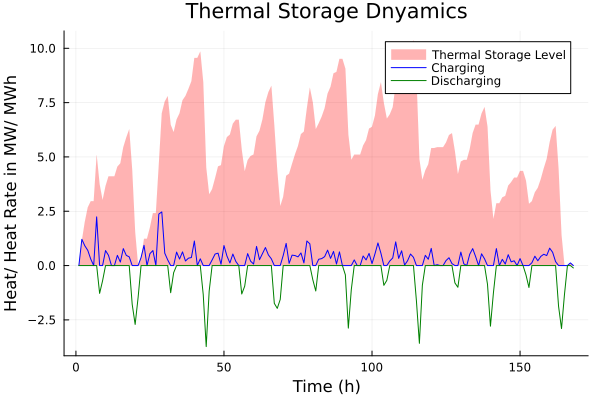

"C:\\Users\\kaush\\Downloads\\thermal_storage_levels.png"

In [165]:
using Plots
p = plot(1:T,opt_S, label = "Thermal Storage Level", ylabel = "Heat/ Heat Rate in MW/ MWh", xlabel = "Time (h)", fillrange=0, lw=0, color=:red, alpha=0.3)
plot!(p, 1:T, opt_rc, label = "Charging", color=:blue)
plot!(p, 1:T, -opt_rd, label = "Discharging", color=:green)
title!("Thermal Storage Dnyamics")
display(p)
savefig("C:\\Users\\kaush\\Downloads\\thermal_storage_levels.png")

Problem 2 - Power System Dispatch Problem

Case A - Optimal Disptach without Ramping Constraints

In [56]:
using CSV, DataFrames
df = CSV.read("C:\\Users\\kaush\\Downloads\\q2_generator_data-2.csv", DataFrame)

Row,Column1,MaxCap (MW),Min Output (MW),Marginal Cost (d_p_MWh),Startup cost (d),Ramp rate (MW/h)
,String15,Int64,Int64,Int64,Int64,Int64?
1,G1 (coal),100,20,20,5000,20
2,G2 (gas),50,10,40,1000,40
3,G3 (gas),30,5,60,500,30
4,G4 (Wind),85,0,0,0,missing


In [57]:
C = Vector{Any}(undef, 4)
C_min = Vector{Any}(undef, 4)
alpha_marg = Vector{Any}(undef, 4)
alpha_start = Vector{Any}(undef, 4)
ramp = Vector{Any}(undef, 4)

for i in 1:4
    C[i] = df[i,2]
    C_min[i] = df[i,3]
    alpha_marg[i] = df[i,4]
    alpha_start[i] = df[i,5]
    ramp[i] = df[i,6]
end

In [58]:
using CSV, DataFrames
df = CSV.read("C:\\Users\\kaush\\Downloads\\q2_demand_cf.csv", DataFrame)
D = df[1:24,2]
wind_CF = df[1:24,3]
show(D)
show(wind_CF)

alpha_L = 1000 # $/MWh
T = 24 # TIme horizon

[80, 70, 60, 55, 50, 60, 70, 100, 120, 140, 150, 160, 170, 160, 150, 140, 130, 120, 110, 100, 90, 80, 70, 60][0.25, 0.3, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 0.75, 0.5, 0.375, 0.25, 0.125, 0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 0.75, 0.5]

24

In [59]:
using JuMP, Gurobi
m1 = Model(Gurobi.Optimizer)

Set parameter Username
Set parameter LicenseID to value 2720373
Academic license - for non-commercial use only - expires 2026-10-09


A JuMP Model
├ solver: Gurobi
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

In [60]:
@variable(m1, P[1:4,1:T]>=0)
@variable(m1, P_L[1:T] >= 0)
@variable(m1, curt[1:T]>=0)
@variable(m1, ST[1:4,1:T], Bin)
@variable(m1, SD[1:4,1:T], Bin)
@variable(m1, y[1:4,1:T], Bin)

4×24 Matrix{VariableRef}:
 y[1,1]  y[1,2]  y[1,3]  y[1,4]  …  y[1,21]  y[1,22]  y[1,23]  y[1,24]
 y[2,1]  y[2,2]  y[2,3]  y[2,4]     y[2,21]  y[2,22]  y[2,23]  y[2,24]
 y[3,1]  y[3,2]  y[3,3]  y[3,4]     y[3,21]  y[3,22]  y[3,23]  y[3,24]
 y[4,1]  y[4,2]  y[4,3]  y[4,4]     y[4,21]  y[4,22]  y[4,23]  y[4,24]

In [61]:
@objective(m1, Min, 
sum(alpha_marg[i]*P[i,t] for i in 1:4, t in 1:T) +
sum(alpha_L*P_L[t] for t in 1:T) +
sum(alpha_start[i]*ST[i,t] for i in 1:4, t in 1:T)
#Shutdown cost is zero, so not considered. 
#Startup costs are considered in the case of no ramping as well
)

20 P[1,1] + 20 P[1,2] + 20 P[1,3] + 20 P[1,4] + 20 P[1,5] + 20 P[1,6] + 20 P[1,7] + 20 P[1,8] + 20 P[1,9] + 20 P[1,10] + 20 P[1,11] + 20 P[1,12] + 20 P[1,13] + 20 P[1,14] + 20 P[1,15] + 20 P[1,16] + 20 P[1,17] + 20 P[1,18] + 20 P[1,19] + 20 P[1,20] + 20 P[1,21] + 20 P[1,22] + 20 P[1,23] + 20 P[1,24] + 40 P[2,1] + 40 P[2,2] + 40 P[2,3] + 40 P[2,4] + 40 P[2,5] + 40 P[2,6] + [[...108 terms omitted...]] + 1000 ST[2,19] + 1000 ST[2,20] + 1000 ST[2,21] + 1000 ST[2,22] + 1000 ST[2,23] + 1000 ST[2,24] + 500 ST[3,1] + 500 ST[3,2] + 500 ST[3,3] + 500 ST[3,4] + 500 ST[3,5] + 500 ST[3,6] + 500 ST[3,7] + 500 ST[3,8] + 500 ST[3,9] + 500 ST[3,10] + 500 ST[3,11] + 500 ST[3,12] + 500 ST[3,13] + 500 ST[3,14] + 500 ST[3,15] + 500 ST[3,16] + 500 ST[3,17] + 500 ST[3,18] + 500 ST[3,19] + 500 ST[3,20] + 500 ST[3,21] + 500 ST[3,22] + 500 ST[3,23] + 500 ST[3,24]

In [62]:
@constraint(m1, [i=1:4, t=1:T], P[i,t] >= C_min[i]*y[i,t])
@constraint(m1, [i=1:4, t=1:T], P[i,t] <= C[i]*y[i,t])
@constraint(m1, [i=1:4, t=1:T], P[4,t] + curt[t] == wind_CF[t]*C[4])
@constraint(m1, demand_balance[t=1:T], sum(P[i,t] for i in 1:4) == D[t])

#Generator status tracker for startup costs

@constraint(m1, [i=1:4, t=2:T], y[i,t] == y[i,t-1] + ST[i,t] - SD[i,t])
@constraint(m1, [i=1:4], y[i,1] == y[i,T]) # Generator state at start and end of horizon (t=24) is the same.

4-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 y[1,1] - y[1,24] == 0
 y[2,1] - y[2,24] == 0
 y[3,1] - y[3,24] == 0
 y[4,1] - y[4,24] == 0

In [63]:
optimize!(m1)

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: AMD Ryzen 7 7735U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 408 rows, 432 columns and 1024 nonzeros
Model fingerprint: 0x4b2d4fb5
Variable types: 144 continuous, 288 integer (288 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e+01, 5e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Found heuristic solution: objective 106205.00000
Presolve removed 283 rows and 240 columns
Presolve time: 0.00s
Presolved: 125 rows, 192 columns, 413 nonzeros
Found heuristic solution: objective 74930.000000
Variable types: 39 continuous, 153 integer (153 binary)

Root relaxation: objective 3.794000e+04, 55 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj

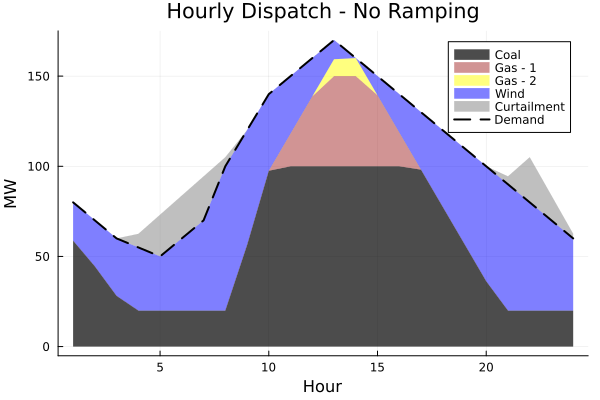

"C:\\Users\\kaush\\Downloads\\Hourly_Dispatch_NoRamp.png"

In [64]:
opt_Gen1 = value.(P[1,1:24])
opt_Gen2 = value.(P[2,1:24])
opt_Gen3 = value.(P[3,1:24])
opt_Gen4 = value.(P[4,1:24])

# Hourly Dispatch results
using Plots
p = plot(1:T, opt_Gen1, fillrange=0, fillalpha=0.7, label="Coal", lw=0, color=:black)
plot!(p, 1:T, opt_Gen1 .+ opt_Gen2, fillrange=opt_Gen1, fillalpha=0.5, label="Gas - 1", lw=0, color=:brown)
plot!(p, 1:T, opt_Gen1 .+ opt_Gen2 .+ opt_Gen3, fillrange=opt_Gen1 .+ opt_Gen2, fillalpha=0.5, label="Gas - 2", lw=0, color=:yellow)
plot!(p, 1:T, opt_Gen1 .+ opt_Gen2 .+ opt_Gen3 .+ opt_Gen4, fillrange=opt_Gen1 .+ opt_Gen2 .+ opt_Gen3, fillalpha=0.5, label="Wind", lw=0, color=:blue)
plot!(p, 1:T, opt_Gen1 .+ opt_Gen2 .+ opt_Gen3 .+ opt_Gen4 .+ value.(curt), fillrange=opt_Gen1 .+ opt_Gen2 .+ opt_Gen3 .+opt_Gen4, fillalpha=0.5, label="Curtailment", lw=0, color=:gray)
plot!(p, 1:T, D, label="Demand", lw=2, linestyle=:dash, color=:black)
title!("Hourly Dispatch - No Ramping")
xlabel!("Hour")
ylabel!("MW")
display(p)
savefig("C:\\Users\\kaush\\Downloads\\Hourly_Dispatch_NoRamp.png")

In [65]:
# Wind Curtailment

wind_curt = sum(value.(curt[t]) for t in 1:24)
wind_prod = C[4] *sum(value.(wind_CF[t]) for t in 1:24)
wind_curt_frac = wind_curt/wind_prod

0.12249970410699491

In [ ]:
# Marginal prices

y_star_ramp = value.(y[:,:])
ST_star_ramp = value.(ST[:,:])
SD_star_ramp = value.(SD[:,:])

fix.(y,y_star_ramp; force = true)
fix.(ST,ST_star_ramp; force = true)
fix.(SD,SD_star_ramp; force = true)

unset_binary.(y)
unset_binary.(ST)
unset_binary.(SD)

optimize!(m1)
price_no_ramp = dual.(m1[:demand_balance])


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: AMD Ryzen 7 7735U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 408 rows, 432 columns and 1024 nonzeros
Model fingerprint: 0x7aa0f4b4
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e+01, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 408 rows and 432 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.7940000e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.794000000e+04

User-callback calls 58, time in user-callback 0.00 sec


"C:\\Users\\kaush\\Downloads\\LMP_NoRamp.png"

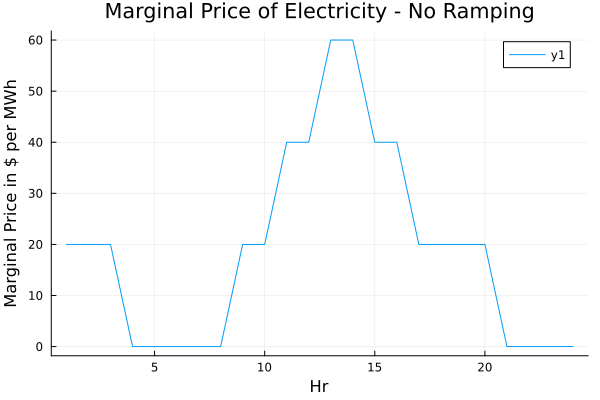

"C:\\Users\\kaush\\Downloads\\LMP_NoRamp.png"

In [88]:
p = plot(1:T, price_no_ramp, ylabel = "Marginal Price in \$ per MWh", xlabel = "Hr", title = "Marginal Price of Electricity - No Ramping")
display(p)
savefig("C:\\Users\\kaush\\Downloads\\LMP_NoRamp.png")

Optimal Disptach with Ramping Constraints

In [74]:
using JuMP, Gurobi
m2 = Model(Gurobi.Optimizer)

Set parameter Username
Set parameter LicenseID to value 2720373
Academic license - for non-commercial use only - expires 2026-10-09


A JuMP Model
├ solver: Gurobi
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

In [75]:
@variable(m2, P[1:4,1:T]>=0)
@variable(m2, P_L[1:T] >= 0)
@variable(m2, curt[1:T]>= 0)
@variable(m2, ST[1:4, 1:T], Bin)
@variable(m2, SD[1:4, 1:T], Bin)
@variable(m2, y[1:4, 1:T], Bin)

4×24 Matrix{VariableRef}:
 y[1,1]  y[1,2]  y[1,3]  y[1,4]  …  y[1,21]  y[1,22]  y[1,23]  y[1,24]
 y[2,1]  y[2,2]  y[2,3]  y[2,4]     y[2,21]  y[2,22]  y[2,23]  y[2,24]
 y[3,1]  y[3,2]  y[3,3]  y[3,4]     y[3,21]  y[3,22]  y[3,23]  y[3,24]
 y[4,1]  y[4,2]  y[4,3]  y[4,4]     y[4,21]  y[4,22]  y[4,23]  y[4,24]

In [76]:
@objective(m2, Min, sum(alpha_marg[i]*P[i,t] for i in 1:4, t in 1:T)
+ sum(alpha_L*P_L[t] for t in 1:T)
+ sum(alpha_start[i]*ST[i,t] for i in 1:4, t in 1:T)
# Shutdown cost is zero, so not considered
)

20 P[1,1] + 20 P[1,2] + 20 P[1,3] + 20 P[1,4] + 20 P[1,5] + 20 P[1,6] + 20 P[1,7] + 20 P[1,8] + 20 P[1,9] + 20 P[1,10] + 20 P[1,11] + 20 P[1,12] + 20 P[1,13] + 20 P[1,14] + 20 P[1,15] + 20 P[1,16] + 20 P[1,17] + 20 P[1,18] + 20 P[1,19] + 20 P[1,20] + 20 P[1,21] + 20 P[1,22] + 20 P[1,23] + 20 P[1,24] + 40 P[2,1] + 40 P[2,2] + 40 P[2,3] + 40 P[2,4] + 40 P[2,5] + 40 P[2,6] + [[...108 terms omitted...]] + 1000 ST[2,19] + 1000 ST[2,20] + 1000 ST[2,21] + 1000 ST[2,22] + 1000 ST[2,23] + 1000 ST[2,24] + 500 ST[3,1] + 500 ST[3,2] + 500 ST[3,3] + 500 ST[3,4] + 500 ST[3,5] + 500 ST[3,6] + 500 ST[3,7] + 500 ST[3,8] + 500 ST[3,9] + 500 ST[3,10] + 500 ST[3,11] + 500 ST[3,12] + 500 ST[3,13] + 500 ST[3,14] + 500 ST[3,15] + 500 ST[3,16] + 500 ST[3,17] + 500 ST[3,18] + 500 ST[3,19] + 500 ST[3,20] + 500 ST[3,21] + 500 ST[3,22] + 500 ST[3,23] + 500 ST[3,24]

In [78]:
@constraint(m2, [i=1:4, t=1:T], P[i,t] >= C_min[i]*y[i,t])
@constraint(m2, [i=1:4, t=1:T], P[i,t] <= C[i]*y[i,t])
@constraint(m2, [i=1:4, t=1:T], P[4,t] + curt[t] == wind_CF[t]*C[4]) # Calculate curtailment from wind separately
@constraint(m2, demand_balance[t=1:T], sum(P[i,t] for i in 1:4) == D[t])

#Generator status tracker for startup costs

@constraint(m2, [i=1:4, t=2:T], y[i,t] == y[i,t-1] + ST[i,t] - SD[i,t])
@constraint(m2, [i=1:4], y[i,1] == y[i,T]) # Generator state at start and end of horizon (t=24) is the same.

4-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 y[1,1] - y[1,24] == 0
 y[2,1] - y[2,24] == 0
 y[3,1] - y[3,24] == 0
 y[4,1] - y[4,24] == 0

In [79]:
# Ramping constraints with generator status tracker
@constraint(m2, [i=1:3, t=2:T], P[i,t] - P[i,t-1] <= ramp[i]*(y[i,t]+SD[i,t])) 
@constraint(m2, [i=1:3, t=2:T], P[i,t-1] - P[i,t] <= ramp[i]*(y[i,t]+ST[i,t])) #Ramp rate is same during normal operation, startup and shutdown

2-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape},2,...} with index sets:
    Dimension 1, Base.OneTo(3)
    Dimension 2, 2:24
And data, a 3×23 Matrix{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape}}:
 P[1,1] - P[1,2] - 20 ST[1,2] - 20 y[1,2] <= 0  …  P[1,23] - P[1,24] - 20 ST[1,24] - 20 y[1,24] <= 0
 P[2,1] - P[2,2] - 40 ST[2,2] - 40 y[2,2] <= 0     P[2,23] - P[2,24] - 40 ST[2,24] - 40 y[2,24] <= 0
 P[3,1] - P[3,2] - 30 ST[3,2] - 30 y[3,2] <= 0     P[3,23] - P[3,24] - 30 ST[3,24] - 30 y[3,24] <= 0

In [80]:
optimize!(m2)

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: AMD Ryzen 7 7735U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 834 rows, 432 columns and 2128 nonzeros
Model fingerprint: 0x12907517
Variable types: 144 continuous, 288 integer (288 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e+01, 5e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 798 rows and 374 columns
Presolve time: 0.01s
Presolved: 36 rows, 58 columns, 110 nonzeros
Variable types: 41 continuous, 17 integer (17 binary)
Found heuristic solution: objective 131902.50000

Root relaxation: objective 4.775250e+04, 15 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node 

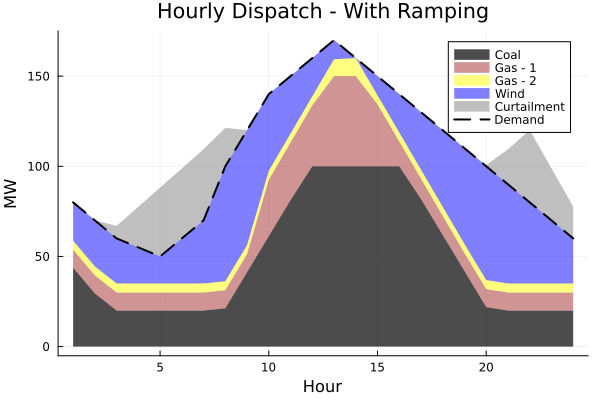

"C:\\Users\\kaush\\Downloads\\Hourly_Dispatch_WithRamp.png"

In [81]:
opt_Gen1 = value.(P[1,1:24])
opt_Gen2 = value.(P[2,1:24])
opt_Gen3 = value.(P[3,1:24])
opt_Gen4 = value.(P[4,1:24])
curt = value.(curt[1:24])

# Hourly Dispatch results
using Plots
p2 = plot(1:T, opt_Gen1, fillrange=0, fillalpha=0.7, label="Coal", lw=0, color=:black)
plot!(p2, 1:T, opt_Gen1 .+ opt_Gen2, fillrange=opt_Gen1, fillalpha=0.5, label="Gas - 1", lw=0, color=:brown)
plot!(p2, 1:T, opt_Gen1 .+ opt_Gen2 .+ opt_Gen3, fillrange=opt_Gen1 .+ opt_Gen2, fillalpha=0.5, label="Gas - 2", lw=0, color=:yellow)
plot!(p2, 1:T, opt_Gen1 .+ opt_Gen2 .+ opt_Gen3 .+ opt_Gen4 , fillrange=opt_Gen1 .+ opt_Gen2 .+ opt_Gen3, fillalpha=0.5, label="Wind", lw=0, color=:blue)
plot!(p2, 1:T, opt_Gen1 .+ opt_Gen2 .+ opt_Gen3 .+ opt_Gen4 .+ curt , fillrange=opt_Gen1 .+ opt_Gen2 .+ opt_Gen3 .+ opt_Gen4 , fillalpha=0.5, label="Curtailment", lw=0, color=:gray)
plot!(p2, 1:T, D, label="Demand", lw=2, linestyle=:dash, color=:black)
title!("Hourly Dispatch - With Ramping")
xlabel!("Hour")
ylabel!("MW")
display(p2)
savefig("C:\\Users\\kaush\\Downloads\\Hourly_Dispatch_WithRamp.png")

In [82]:
# Wind Curtailment

wind_curt = sum(value.(curt[t]) for t in 1:24)
wind_prod = C[4] *sum(value.(wind_CF[t]) for t in 1:24)
wind_curt_frac = wind_curt/wind_prod

0.25861048644810036

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: AMD Ryzen 7 7735U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 834 rows, 432 columns and 2128 nonzeros
Model fingerprint: 0x70af7a07
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e+01, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 799 rows and 380 columns
Presolve time: 0.00s
Presolved: 35 rows, 70 columns, 103 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0862085e+04   6.407813e+01   0.000000e+00      0s
      25    4.7752500e+04   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.775250000e+04

User-callback calls 111, time in user-callback 0.00 sec


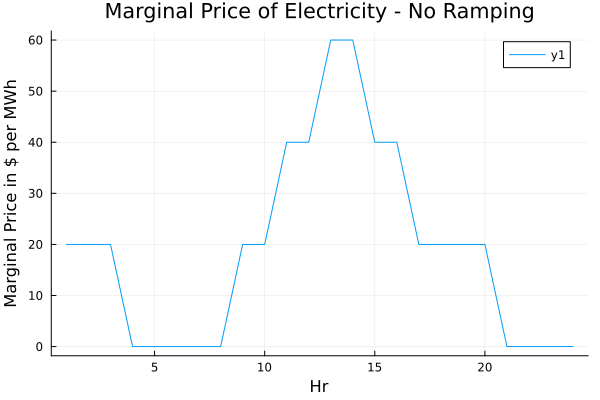

"C:\\Users\\kaush\\Downloads\\LMP_NoRamp.png"

In [ ]:
# Marginal electrcity prices

y_star_ramp = value.(y[:,:])
ST_star_ramp = value.(ST[:,:])
SD_star_ramp = value.(SD[:,:])

fix.(y,y_star_ramp; force = true)
fix.(ST,ST_star_ramp; force = true)
fix.(SD,SD_star_ramp; force = true)

unset_binary.(y)
unset_binary.(ST)
unset_binary.(SD)

optimize!(m2)
price_ramp = dual.(m2[:demand_balance])


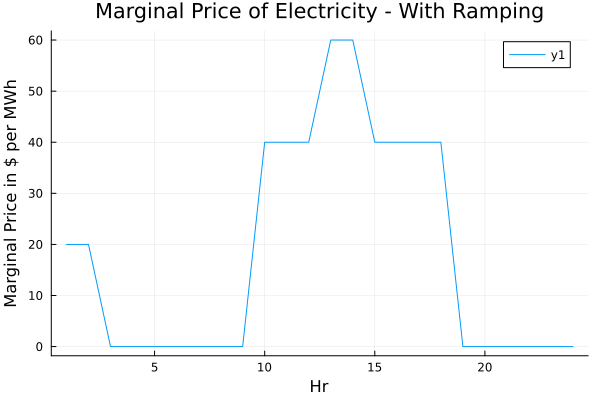

"C:\\Users\\kaush\\Downloads\\LMP_WithRamp.png"

In [89]:
p = plot(1:T, price_ramp, ylabel = "Marginal Price in \$ per MWh", xlabel = "Hr", title = "Marginal Price of Electricity - With Ramping")
display(p)
savefig("C:\\Users\\kaush\\Downloads\\LMP_WithRamp.png")